# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

In [1]:
#Note: I (Shivam) added this just since Im using Google Colab, comment it out if you are doing it in VSCode
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install torchmetrics

1. Load CNN dataset.

In [3]:
### ADD YOUR CODE HERE ###
#THIS IS FROM SHIVAM, FOR ABHISHEK MAKE SURE TO CHANEG THIS TO MATCH YOUR PATH
#Shivam
#dataPath = '/content/gdrive/MyDrive/Colab Notebooks/CSE 676 A1 Shivam Abhishek/cnn_dataset'
#Abhishek
'''dataPath = '/content/gdrive/MyDrive/A1_Dataset/cnn_dataset'''


!cp "/content/gdrive/MyDrive/A1_Dataset/cnn_dataset.zip" /content/



In [4]:
#Planning to unzip the files over here , since when i unzipped and uploaded the files on drive
#it gave me a lot of issue regarding bottle neck
!unzip -q /content/cnn_dataset.zip -d /content/


In [5]:
!ls /content

#While unzipping unzipped inside the content path

bestModel.pth  cnn_dataset.zip	food	sample_data
cnn_dataset    dogs		gdrive	vehicles


In [6]:
!mkdir -p /content/cnn_dataset

#Created a new folder cnn_dataset so that we can move images inside that

In [7]:
!mv /content/dogs /content/cnn_dataset/
!mv /content/food /content/cnn_dataset/
!mv /content/vehicles /content/cnn_dataset/



mv: cannot move '/content/dogs' to '/content/cnn_dataset/dogs': Directory not empty
mv: cannot move '/content/food' to '/content/cnn_dataset/food': Directory not empty
mv: cannot move '/content/vehicles' to '/content/cnn_dataset/vehicles': Directory not empty


In [8]:
!ls /content/cnn_dataset

#Verifying the folder

dogs  food  vehicles


Analyze the dataset.

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import Counter

#the transform line below is based on here: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), #Normalised pixel values to [0-1] from [0-255], RGB
    #Also normalising now since VGG works better with mean/std
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = ImageFolder("/content/cnn_dataset", transform=transform)

print("Total images:", len(dataset))
print("Classes:", dataset.classes)
print(Counter(dataset.targets))

Total images: 30000
Classes: ['dogs', 'food', 'vehicles']
Counter({0: 10000, 1: 10000, 2: 10000})


<span style='color:green'>### YOUR ANSWER ###</span>

From the analysis we can see that this dataset has 3 subfoldersm for dogs, food and vehicles. Each of them has 10000 images inside

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

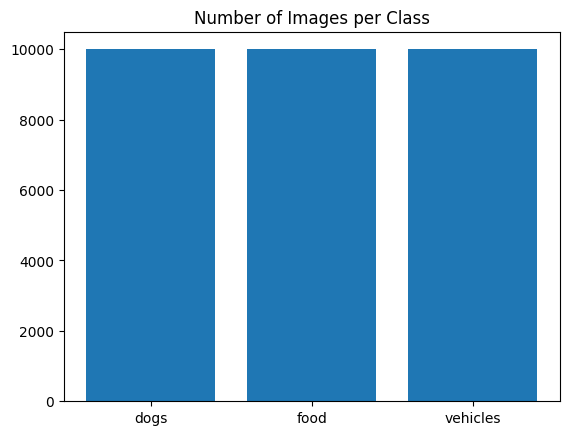

In [3]:
### ADD YOUR CODE HERE ###
#Visualization 1: Number of images per class


import matplotlib.pyplot as plt
from collections import Counter
plt.figure()
count = Counter(dataset.targets)
plt.bar(dataset.classes, count.values())
plt.title('Number of Images per Class')




plt.show()

This bar chart shows the number of images available for each class. As it was previously mentioned we have 3 classes of 10k images per class, thats how the bar graph looks like.

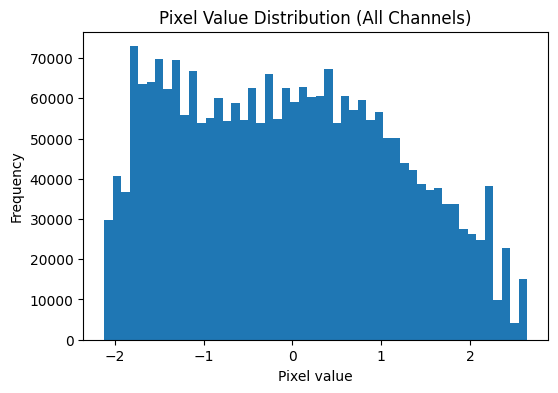

In [4]:
'''#Visualization 2: Histogram of Pixel Values
image, label = dataset[0]
plt.hist(image[0].flatten(), bins=50)
plt.show()'''

import torch

# Take a subset of images
pixels = []

for i in range(200):   # sample first 200 images
    img, _ = dataset[i]
    pixels.append(img.flatten())

pixels = torch.cat(pixels)

plt.figure(figsize=(6,4))
plt.hist(pixels.numpy(), bins=50)
plt.title("Pixel Value Distribution (All Channels)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

The above histogram shows the distribution of pixel values in the dataset. We can see that it has been scaled between 0-1 and also if we need we can choose necessary mean / standard deviation if needed for training

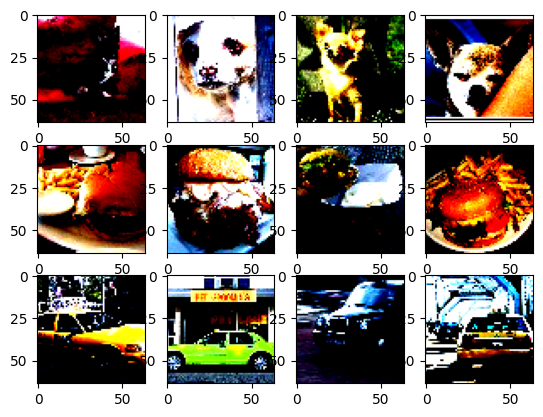

In [5]:

#Visualization 3: grid of sample images
numClasses = len(dataset.classes)
classSamples = {}
for i in range(numClasses):
    classSamples[i] = []

for img, label in dataset:
    if len(classSamples[label]) < 4:
        classSamples[label].append(img)
plt.figure()
plot_index = 1

for class_idx in range(numClasses):
    for img in classSamples[class_idx]:
        plt.subplot(numClasses, 4, plot_index)
        plt.imshow(img.permute(1, 2, 0))
        plot_index += 1

plt.show()


It shows the images present in the different classes, also hughlights the images are not in grey scale and are present in RGB fashion. WE have printed 4 images per class to highlight the different angles or possibilities of how the image has been captured for training . Since we have used normalisation the images shown is clipped, warning but still workable

3. Preprocess the dataset.

In [6]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Based on here https://www.kaggle.com/code/subhajeetdas/1-pytorch-cuda-check
print(len(dataset.classes))
print(device)


3
cuda


4. Split the dataset into training, testing, and validation sets.

In [7]:
'''### ADD YOUR CODE HERE ###
#Next doing a train-test split of 80-20
trainSet, testSet = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))]) #Based on here: https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split
trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=True)'''

from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)
train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # To ensure it sums exactly

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

'''train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)'''

'''print(len(train_loader))
print(len(val_loader))
print(len(test_loader))'''

'print(len(train_loader))\nprint(len(val_loader))\nprint(len(test_loader))'

## Step 2: Implementing VGG

In [8]:
!pip install torchinfo

1. Implement the VGG-16 (Version C) architecture.

In [9]:
### ADD YOUR CODE HERE ###
import torch
import torch.nn as nn

class vgg16(nn.Module):
    def __init__(self, numClasses): #base image is 64*64
        super(vgg16, self).__init__()

        #Start with input channels as 3 and create 64 feature maps  of kernel size 3*3
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        #Keep the feature maps same
        self.conv2 = nn.Conv2d(64,64,3,padding=1)

        #half the size (64*32*32)
        self.pool1 = nn.MaxPool2d(2,2)


        #Increase the output channels to 128*32*32
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)

        #Max pool again 128*16*16
        self.pool2 = nn.MaxPool2d(2,2)

        #Conv Block 3
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)

        #Pooling becomes 256*8*8
        self.pool3 = nn.MaxPool2d(2,2)

        # outputs 256x1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        #Fully Connected Layers
        self.fc1 = nn.Linear(256*1*1, 512)

        #Convert 512 neurons to 256 features
        self.fc2 = nn.Linear(512, 256)

        #Normally for Vgg16 it is 1000, but since we have 3 classes it will be 3
        self.fc3 = nn.Linear(256, numClasses)


        #Activation function
        self.relu = nn.ReLU()



        #Droput
        self.drop = nn.Dropout(p=0.3)  # reduced dropout for small dataset



    def forward(self, x):

        #Calling relu and conv2d function
        out = self.relu(self.conv1(x))
        #passing the output as the next input for the rest
        out = self.relu(self.conv2(out))
        out = self.pool1(out)

      #passing the output as the next input for the rest
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.pool2(out)

        #passing the output as the next input for the rest
        out = self.relu(self.conv5(out))
        out = self.relu(self.conv6(out))
        out = self.relu(self.conv7(out))
        out = self.pool3(out)

        #passing the output as the next input for the rest
        out = self.avgpool(out)
        out = torch.flatten(out,1)

        #passing the output as the next input for the rest
        out = self.relu(self.fc1(out))
        out = self.drop(out)

        #passing the output as the next input for the rest
        out = self.relu(self.fc2(out))
        out = self.drop(out)

        #no relu here since it is raw logits
        out = self.fc3(out)



        return out

In [10]:
### ADD YOUR CODE HERE ###
from torchinfo import summary

# Create the model and send it to device
'''model = vgg16(3).to(device)  # 3 classes

# Print model summary for input size 64x64 and batch size 1
summary(model, input_size=(1, 3, 64, 64))'''

#Now creating two objecsts for the model

model_he = vgg16(numClasses=3).to(device)
model_xavier = vgg16(numClasses=3).to(device)

summary(model_he, input_size=(1, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
vgg16                                    [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,792
├─ReLU: 1-2                              [1, 64, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           36,928
├─ReLU: 1-4                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─Conv2d: 1-6                            [1, 128, 32, 32]          73,856
├─ReLU: 1-7                              [1, 128, 32, 32]          --
├─Conv2d: 1-8                            [1, 128, 32, 32]          147,584
├─ReLU: 1-9                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-10                        [1, 128, 16, 16]          --
├─Conv2d: 1-11                           [1, 256, 16, 16]          295,168
├─ReLU: 1-12                             [1, 256, 16, 16]       

In [11]:
summary(model_xavier, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
vgg16                                    [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,792
├─ReLU: 1-2                              [1, 64, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           36,928
├─ReLU: 1-4                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─Conv2d: 1-6                            [1, 128, 32, 32]          73,856
├─ReLU: 1-7                              [1, 128, 32, 32]          --
├─Conv2d: 1-8                            [1, 128, 32, 32]          147,584
├─ReLU: 1-9                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-10                        [1, 128, 16, 16]          --
├─Conv2d: 1-11                           [1, 256, 16, 16]          295,168
├─ReLU: 1-12                             [1, 256, 16, 16]       

2. Use dropout and learning rate scheduler. Experiment with weight initialization strategies.

a) Xavier (Glorot) Initialization

Can be aplied with ReLU or Tanh activations

In [12]:
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [13]:
# Model with Xavier initialization
model_xavier = vgg16(numClasses=3).to(device)
model_xavier.apply(weights_init_xavier)

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Line

b) He (Kaiming) Initialization

Works well with ReLU activations



In [14]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [15]:
# Model with He initialization
model_he = vgg16(numClasses=3).to(device)
model_he.apply(weights_init_he)

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Line

In [16]:
### ADD YOUR CODE HERE ###
import torch.optim as optim

#Dropout already declared in the vgg model

'''# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Learning rate scheduler
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)'''


#The above was decalred but since we would need to experiment with difeerent weights and batch sizes
#its better to have different models



# For model_he
optimizer_he = optim.Adam(model_he.parameters(), lr=0.003, weight_decay=1e-4)
scheduler_he = optim.lr_scheduler.StepLR(optimizer_he, step_size=5, gamma=0.5)

# For model_xavier
optimizer_xavier = optim.Adam(model_xavier.parameters(), lr=0.003, weight_decay=1e-4)
scheduler_xavier = optim.lr_scheduler.StepLR(optimizer_xavier, step_size=5, gamma=0.5)

The goal of weight initialization

Deep networks like VGG16 are very sensitive to initialization.

If weights are too large → activations explode, gradients explode → training fails

If weights are too small → activations vanish, gradients vanish → training is very slow

In [17]:
#SInce the experimenting is required on two differnet batch sizes
train_loader_32 = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader_32 = DataLoader(val_set, batch_size=32, shuffle=True)


train_loader_64 = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader_64 = DataLoader(val_set, batch_size=64, shuffle=True)


print(len(train_loader_32))
print(len(train_loader_64))

657
329


3. Train your VGG-16 model.

In [18]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=15):
    criterion = nn.CrossEntropyLoss()
    trainAccs, valAccs = [], []
    trainLoss, valLoss = [], []

    for epoch in range(epochs):
        model.train()
        runningLoss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss_val = criterion(out, y)
            loss_val.backward()
            optimizer.step()
            runningLoss += loss_val.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        trainLossEpoch = runningLoss / len(train_loader)
        trainAccEpoch = correct / total
        trainLoss.append(trainLossEpoch)
        trainAccs.append(trainAccEpoch)

        model.eval()
        runningValLoss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_val = criterion(out, y)
                runningValLoss += loss_val.item()
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        valLossEpoch = runningValLoss / len(val_loader)
        valAccEpoch = correct / total
        valLoss.append(valLossEpoch)
        valAccs.append(valAccEpoch)

        scheduler.step()

        # Print losses and accuracies after every epoch
        print(f"Epoch {epoch+1}: "
              f"TrainLoss={trainLossEpoch:.4f}, ValLoss={valLossEpoch:.4f}, "
              f"TrainAcc={trainAccEpoch:.4f}, ValAcc={valAccEpoch:.4f}")

    return trainLoss, trainAccs, valLoss, valAccs

In [19]:
#WE can have 2 possible combinations with he -> 32,64
#but im taking he with batch size = 32 only
trainLoss_he32, trainAcc_he32, valLoss_he32, valAcc_he32 = train_model(
    model_he,
    train_loader_32,
    val_loader_32,
    optimizer_he,
    scheduler_he,
    epochs=15
)

Epoch 1: TrainLoss=0.8666, ValLoss=0.4376, TrainAcc=0.7025, ValAcc=0.8364
Epoch 2: TrainLoss=0.4138, ValLoss=0.3684, TrainAcc=0.8459, ValAcc=0.8598
Epoch 3: TrainLoss=0.3429, ValLoss=0.3010, TrainAcc=0.8716, ValAcc=0.8889
Epoch 4: TrainLoss=0.3186, ValLoss=0.3240, TrainAcc=0.8860, ValAcc=0.8769
Epoch 5: TrainLoss=0.2972, ValLoss=0.3269, TrainAcc=0.8909, ValAcc=0.8744
Epoch 6: TrainLoss=0.2349, ValLoss=0.3281, TrainAcc=0.9142, ValAcc=0.8740
Epoch 7: TrainLoss=0.2208, ValLoss=0.2654, TrainAcc=0.9190, ValAcc=0.9042
Epoch 8: TrainLoss=0.2078, ValLoss=0.2718, TrainAcc=0.9263, ValAcc=0.9056
Epoch 9: TrainLoss=0.1983, ValLoss=0.2478, TrainAcc=0.9286, ValAcc=0.9140
Epoch 10: TrainLoss=0.1865, ValLoss=0.2223, TrainAcc=0.9332, ValAcc=0.9160
Epoch 11: TrainLoss=0.1438, ValLoss=0.2399, TrainAcc=0.9489, ValAcc=0.9156
Epoch 12: TrainLoss=0.1316, ValLoss=0.2344, TrainAcc=0.9526, ValAcc=0.9200
Epoch 13: TrainLoss=0.1206, ValLoss=0.2972, TrainAcc=0.9564, ValAcc=0.9100
Epoch 14: TrainLoss=0.1140, ValLos

In [20]:
#WE can have 2 possible combinations with xavier -> 32,64
#but im taking xavier with batch size = 64 only
trainLoss_x64, trainAcc_x64, valLoss_x64, valAcc_x64 = train_model(
    model_xavier,
    train_loader_64,
    val_loader_64,
    optimizer_xavier,
    scheduler_xavier,
    epochs=15
)

Epoch 1: TrainLoss=0.7750, ValLoss=0.5833, TrainAcc=0.6800, ValAcc=0.7813
Epoch 2: TrainLoss=0.4723, ValLoss=0.4368, TrainAcc=0.8150, ValAcc=0.8336
Epoch 3: TrainLoss=0.4116, ValLoss=0.4102, TrainAcc=0.8400, ValAcc=0.8473
Epoch 4: TrainLoss=0.3909, ValLoss=0.4004, TrainAcc=0.8519, ValAcc=0.8344
Epoch 5: TrainLoss=0.3756, ValLoss=0.3382, TrainAcc=0.8540, ValAcc=0.8709
Epoch 6: TrainLoss=0.3087, ValLoss=0.4006, TrainAcc=0.8851, ValAcc=0.8491
Epoch 7: TrainLoss=0.2922, ValLoss=0.3241, TrainAcc=0.8926, ValAcc=0.8789
Epoch 8: TrainLoss=0.2764, ValLoss=0.2837, TrainAcc=0.8996, ValAcc=0.8931
Epoch 9: TrainLoss=0.2720, ValLoss=0.2667, TrainAcc=0.9011, ValAcc=0.9040
Epoch 10: TrainLoss=0.2555, ValLoss=0.2707, TrainAcc=0.9078, ValAcc=0.8969
Epoch 11: TrainLoss=0.2223, ValLoss=0.2424, TrainAcc=0.9182, ValAcc=0.9151
Epoch 12: TrainLoss=0.2142, ValLoss=0.2473, TrainAcc=0.9226, ValAcc=0.9124
Epoch 13: TrainLoss=0.2084, ValLoss=0.2410, TrainAcc=0.9235, ValAcc=0.9120
Epoch 14: TrainLoss=0.2049, ValLos

4. Apply regularization and overfitting prevention techniques.

In [21]:
### ADD YOUR CODE HERE ###


#Augmentation code, making changes so that we can capture different spatiality of the image
train_transforms_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


'''val_test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])'''

In [22]:
dataset_aug = ImageFolder("/content/cnn_dataset", transform=train_transforms_aug)

# Optionally, split into train/val/test (70%-15%-15%)
dataset_size = len(dataset_aug)
train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set_aug, val_set_aug, test_set_aug = torch.utils.data.random_split(
    dataset_aug, [train_size, val_size, test_size]
)

In [23]:
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader_aug   = DataLoader(val_set_aug, batch_size=32, shuffle=False)
test_loader_aug  = DataLoader(test_set_aug, batch_size=32, shuffle=False)

In [25]:
#Copy paste the same training model function with additon of early stopping
def train_model_earlystop(model, train_loader, val_loader, optimizer, scheduler, epochs=15, patience=5):
    criterion = nn.CrossEntropyLoss()
    trainAccs, valAccs = [], []
    trainLoss, valLoss = [], []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        runningLoss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss_val = criterion(out, y)
            loss_val.backward()
            optimizer.step()

            runningLoss += loss_val.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        trainLossEpoch = runningLoss / len(train_loader)
        trainAccEpoch = correct / total
        trainLoss.append(trainLossEpoch)
        trainAccs.append(trainAccEpoch)

        # Validation
        model.eval()
        runningValLoss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_val = criterion(out, y)
                runningValLoss += loss_val.item()
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        valLossEpoch = runningValLoss / len(val_loader)
        valAccEpoch = correct / total
        valLoss.append(valLossEpoch)
        valAccs.append(valAccEpoch)

        scheduler.step()

        # Early stopping: save best model and stop if no improvement
        if valLossEpoch < best_val_loss - 1e-4:
            best_val_loss = valLossEpoch
            counter = 0
            torch.save(model.state_dict(), "best_model_he_aug.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}: "
              f"TrainLoss={trainLossEpoch:.4f}, ValLoss={valLossEpoch:.4f}, "
              f"TrainAcc={trainAccEpoch:.4f}, ValAcc={valAccEpoch:.4f}")

    # Load best weights
    model.load_state_dict(torch.load("best_model_he_aug.pth"))

    return trainLoss, trainAccs, valLoss, valAccs

In [26]:
trainLoss_he_aug, trainAcc_he_aug, valLoss_he_aug, valAcc_he_aug = train_model_earlystop(
    model_he,
    train_loader_aug,
    val_loader_aug,
    optimizer_he,
    scheduler_he,
    epochs=50,      # you can set higher since early stopping will cut short
    patience=5
)

Epoch 1: TrainLoss=0.2702, ValLoss=0.2516, TrainAcc=0.9004, ValAcc=0.9031
Epoch 2: TrainLoss=0.2416, ValLoss=0.2484, TrainAcc=0.9122, ValAcc=0.9089
Epoch 3: TrainLoss=0.2370, ValLoss=0.2375, TrainAcc=0.9120, ValAcc=0.9107
Epoch 4: TrainLoss=0.2244, ValLoss=0.2367, TrainAcc=0.9171, ValAcc=0.9091
Epoch 5: TrainLoss=0.2193, ValLoss=0.2249, TrainAcc=0.9182, ValAcc=0.9164
Epoch 6: TrainLoss=0.2031, ValLoss=0.2109, TrainAcc=0.9247, ValAcc=0.9233
Epoch 7: TrainLoss=0.1981, ValLoss=0.2118, TrainAcc=0.9259, ValAcc=0.9222
Epoch 8: TrainLoss=0.1978, ValLoss=0.2036, TrainAcc=0.9269, ValAcc=0.9256
Epoch 9: TrainLoss=0.1937, ValLoss=0.2172, TrainAcc=0.9293, ValAcc=0.9202
Epoch 10: TrainLoss=0.1917, ValLoss=0.2171, TrainAcc=0.9305, ValAcc=0.9224
Epoch 11: TrainLoss=0.1873, ValLoss=0.2042, TrainAcc=0.9306, ValAcc=0.9196
Epoch 12: TrainLoss=0.1787, ValLoss=0.1953, TrainAcc=0.9330, ValAcc=0.9251
Epoch 13: TrainLoss=0.1811, ValLoss=0.2138, TrainAcc=0.9323, ValAcc=0.9176
Epoch 14: TrainLoss=0.1779, ValLos

5. Evaluation and analysis.

In [27]:
from sklearn.metrics import accuracy_score
import torch.nn as nn
#On test dataset
def evaluate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, all_labels, all_preds

'### ADD YOUR CODE HERE ###\n\n\nhe Initialization (First block of epochs)\n\nFinal Train Accuracy: 96.57%\n\nFinal Val Accuracy: 92.07%\n\nObservations:\n\nVery fast convergence in the first few epochs (TrainAcc jumps from 70% → 88% in 4 epochs).\n\nSlight overfitting towards the end (TrainAcc keeps increasing while ValAcc fluctuates between 91–92%).\n\nValidation loss sometimes increases slightly (e.g., epoch 13–14) while training loss decreases → typical overfitting sign.\n\n✅ Interpretation:\nHe initialization works well with ReLU and gives strong convergence. Dropout helped, but you might still squeeze a bit more generalization.\n2️⃣ Xavier Initialization (Second block of epochs)\n\nFinal Train Accuracy: 93.30%\n\nFinal Val Accuracy: 91.22%\n\nObservations:\n\nSlower convergence than He initialization (starts lower at 68% vs 70%).\n\nTraining loss decreases steadily, but validation accuracy is slightly lower than He.\n\nAlso shows some overfitting in later epochs, but not as prono

In [28]:
test_loss, test_acc, y_true, y_pred = evaluate_model(model_he, test_loader_aug)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1583
Test Accuracy: 0.9409


In [29]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9410
Recall: 0.9409
F1-score: 0.9409


Observation

As observed in the HE weight initalisaiton

Val accuracy : 92.07 and train accuracy is around 96.57%
Convergence in the first epochs are very fast
Val loss increases slightly but not much so less chance of overfiting



As observed in the Xavier Initialization

Final Val Accuracy: 91.22%

Convergence is comparitevly slower than HE, training loss is decreasing streadily , but validation accuracy when checked is lower than HE , hence HE would be the base model with best result



6. Save the weights of the trained network.

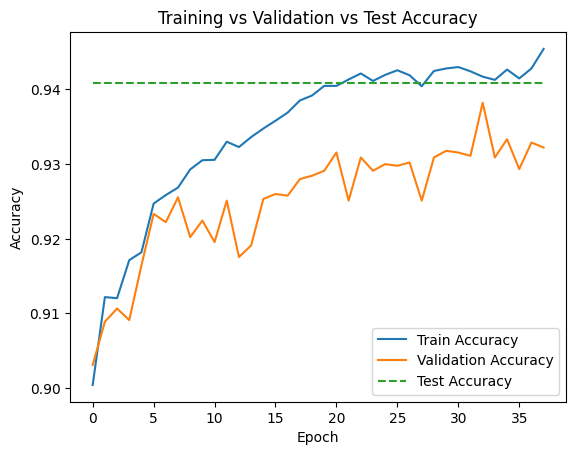

In [38]:
### ADD YOUR CODE HERE ###

#Train vs Test  vs Validation accuracy
import matplotlib.pyplot as plt


epochs = len(trainAcc_he_aug)

test_acc_line = [test_acc] * epochs

plt.figure()
plt.plot(trainAcc_he_aug, label='Train Accuracy')
plt.plot(valAcc_he_aug, label='Validation Accuracy')
plt.plot(test_acc_line, label='Test Accuracy', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation vs Test Accuracy')
plt.legend()
plt.show()

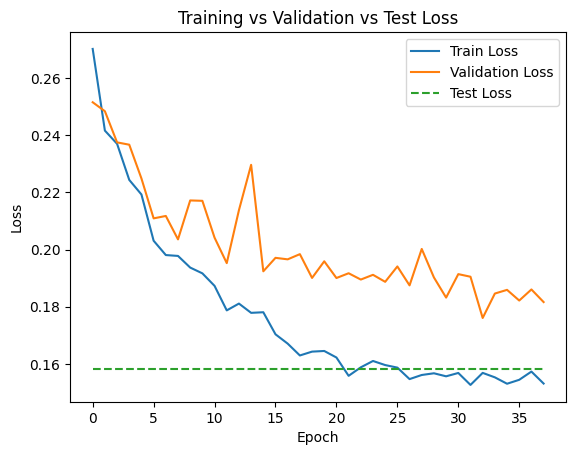

In [32]:

#Loss accuracy
test_loss_line = [test_loss] * epochs

plt.figure()
plt.plot(trainLoss_he_aug, label='Train Loss')
plt.plot(valLoss_he_aug, label='Validation Loss')
plt.plot(test_loss_line, label='Test Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss')
plt.legend()
plt.show()

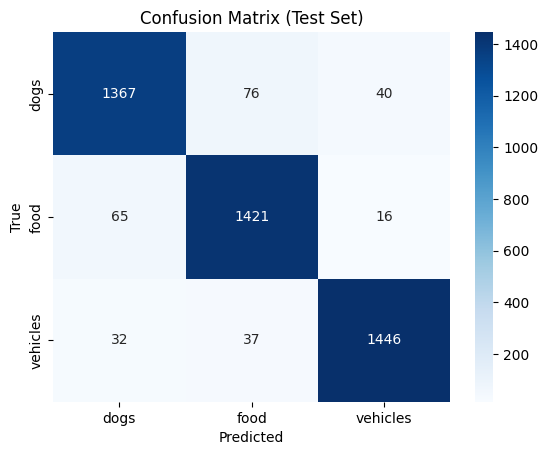

In [33]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

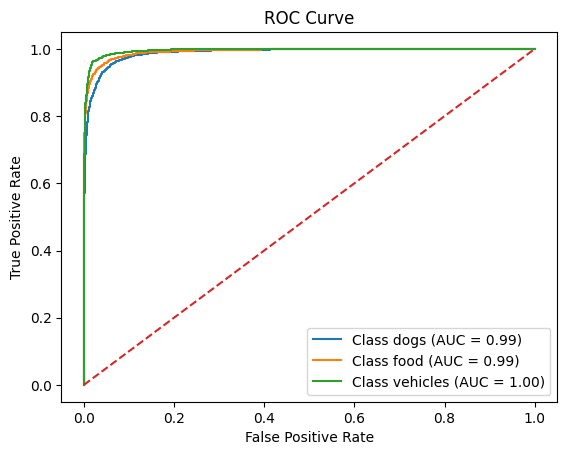

In [34]:
#ROC Curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probabilities
model_he.eval()
probs = []

with torch.no_grad():
    for x, _ in test_loader_aug:
        x = x.to(device)
        outputs = model_he(x)
        probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

probs = np.array(probs)

# Binarize labels
n_classes = len(dataset.classes)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

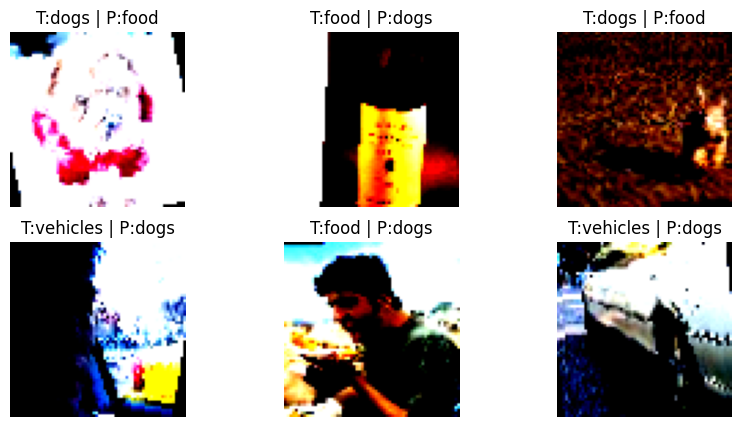

In [35]:
import random

model_he.eval()
misclassified = []

with torch.no_grad():
    for x, y in test_loader_aug:
        x, y = x.to(device), y.to(device)
        outputs = model_he(x)
        preds = outputs.argmax(1)

        for i in range(len(y)):
            if preds[i] != y[i]:
                misclassified.append((x[i].cpu(), y[i].cpu(), preds[i].cpu()))

# Show few examples
plt.figure(figsize=(10,5))
for i in range(min(6, len(misclassified))):
    img, true, pred = misclassified[i]
    img = img.permute(1,2,0)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"T:{dataset.classes[true]} | P:{dataset.classes[pred]}")
    plt.axis('off')

plt.show()

Eror can be because of low pixel, poor lighting

In [36]:
torch.save(model_he.state_dict(), "best_vgg16_model.pth")

In [37]:
model_he.load_state_dict(torch.load("best_vgg16_model.pth"))
model_he.eval()

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Line

## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [39]:
import torch.nn as nn

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()


    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    #Applying activation function
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    #If size of image changes , then make changes else keep as it is
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    output = self.relu(self.bn1(self.conv1(x)))
    output = self.bn2(self.conv2(output))
    output += self.shortcut(x)
    output = self.relu(output)
    return output




2. Assemble the ResNet-18 architecture.

In [40]:
from torchsummary import summary

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

class ResNet18(nn.Module):
    def __init__(self, numClasses, in_channels=3):  # specify input channels
        super(ResNet18, self).__init__()
        self.in_channels = 64  # for residual blocks

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 3x3 for small images
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # skip maxpool for small 64x64 images

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Average pooling and fully connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, numClasses)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage
'''model = ResNet18(numClasses=3, in_channels=3)  # RGB images, 3 classes
summary(model, input_size=(3, 64, 64))'''

'model = ResNet18(numClasses=3, in_channels=3)  # RGB images, 3 classes\nsummary(model, input_size=(3, 64, 64))'

In [42]:
modelResnet = ResNet18(numClasses=3, in_channels=3).to(device)
summary(modelResnet, input_size=(3, 64, 64))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

criterion = nn.CrossEntropyLoss()  # good for multi-class classification
optimizer = optim.Adam(modelResnet.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
          Identity-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
         Identity-10           [-1, 64, 64, 64]               0
             ReLU-11           [-1, 64, 64, 64]               0
    ResidualBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
num_epochs = 10  # adjust as needed

for epoch in range(num_epochs):
    # --------------------------
    # Training
    # --------------------------
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item() * images.size(0)

        # Accumulate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train

    # --------------------------
    # Validation
    # --------------------------
    model.eval()
    val_loss_running = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss_running += loss.item() * images.size(0)

            # Accumulate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss_running / len(val_loader.dataset)
    val_acc = correct_val / total_val

    # --------------------------
    # Print metrics
    # --------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/10] Train Loss: 0.4934, Train Acc: 0.8159 Val Loss: 0.4159, Val Acc: 0.8411
Epoch [2/10] Train Loss: 0.3451, Train Acc: 0.8698 Val Loss: 0.3423, Val Acc: 0.8716
Epoch [3/10] Train Loss: 0.2901, Train Acc: 0.8918 Val Loss: 0.5812, Val Acc: 0.7624
Epoch [4/10] Train Loss: 0.2676, Train Acc: 0.9005 Val Loss: 0.2876, Val Acc: 0.8902
Epoch [5/10] Train Loss: 0.2331, Train Acc: 0.9143 Val Loss: 0.3559, Val Acc: 0.8684
Epoch [6/10] Train Loss: 0.2098, Train Acc: 0.9214 Val Loss: 0.2477, Val Acc: 0.9100
Epoch [7/10] Train Loss: 0.1997, Train Acc: 0.9250 Val Loss: 0.3128, Val Acc: 0.8904
Epoch [8/10] Train Loss: 0.1825, Train Acc: 0.9309 Val Loss: 0.2476, Val Acc: 0.9073
Epoch [9/10] Train Loss: 0.1658, Train Acc: 0.9386 Val Loss: 0.4289, Val Acc: 0.8662
Epoch [10/10] Train Loss: 0.2023, Train Acc: 0.9252 Val Loss: 0.2829, Val Acc: 0.8873


In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize metrics
correct_test = 0
total_test = 0
test_loss_running = 0.0

# Use no_grad() for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumulate loss
        test_loss_running += loss.item() * images.size(0)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Compute average loss and accuracy
test_loss = test_loss_running / len(test_loader.dataset)
test_acc = correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.2850, Test Accuracy: 0.8889


3. Train the ResNet-18 model.

In [ ]:
### ADD YOUR CODE HERE ###

4. Apply regularization techniques.

In [ ]:
### ADD YOUR CODE HERE ###

5. Evaluation and analysis.

In [ ]:
### ADD YOUR CODE HERE ###

6. Save the weights of the trained network.

In [ ]:
### ADD YOUR CODE HERE ###

## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.

<span style='color:green'>### YOUR ANSWER ###</span>

2. Discuss the impact of regularization and optimization techniques.

<span style='color:green'>### YOUR ANSWER ###</span>

3. Analyze the results, including all required graphs and metrics.

<span style='color:green'>### YOUR ANSWER ###</span>

4. Summarize your findings and discuss the advantages of residual connections.

<span style='color:green'>### YOUR ANSWER ###</span>

5. References.

<span style='color:green'>### YOUR ANSWER ###</span>
1) https://docs.pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
2) https://docs.pytorch.org/docs/stable/nn.init.html


## Step 5: Deploy the model

Upload the video to UBBox and share the publicly available recording link in the Markdown cell below.